In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Read the data
X_full = pd.read_csv('/content/drive/MyDrive/data_research/data.csv')
columns = ['asset_price', 'maturity', 'rate', 'div', 'ivol', 'eu_price', 'am_price'] 
X_full.columns = columns

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['am_price'], inplace=True)
y = X_full.am_price
X_full.drop(['am_price'], axis=1, inplace=True)


# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns with relatively low cardinality 
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()



In [3]:
X_train.head()

,asset_price,maturity,rate,div,ivol,eu_price
3972,116.025713,0.820349,0.032117,0.081244,0.562491,15.587932
5932,122.579343,0.374312,0.094859,0.000000,0.411720,2.499845
4787,114.890931,0.374259,0.016274,0.087227,0.355693,4.400367
2380,78.600814,3.123196,0.020283,0.006259,0.439053,34.982935
675,97.571564,0.929457,0.051670,0.073215,0.528091,20.883309


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = XGBRegressor(n_estimators=5000, random_state=0, learning_rate=0.07, n_jobs=4)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

[03:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.1093773251759007


In [5]:
from sklearn.model_selection import cross_val_score
def get_score(n_estimators, learning_rate, n_jobs):
    # Replace this body with your own code
    local_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=n_jobs, random_state=0))])
    
    scores = -1 * cross_val_score(local_pipeline, X_full, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    return scores.mean()

In [6]:
import warnings
warnings.filterwarnings("ignore")

results = {}
for i in range(15):
    results[(i+1)*50] = get_score((i+1)*50, learning_rate=0.07, n_jobs=4)


[03:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

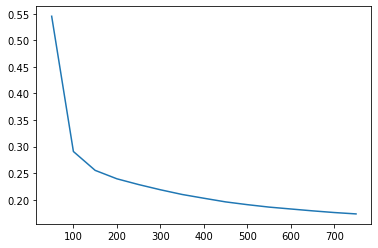

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [20]:
min = 50
for i in range(15):
    if results[(i+1)*50] < results[min]:
      min=(i+1)*50
results[min]

0.1732310169987386

In [24]:
min_average_error_in_pct = results[min] / y_train.mean()

In [26]:
print(round(100*min_average_error_in_pct,2), '%')

1.11 %
